<a href="https://colab.research.google.com/github/ap3s-plan3t/Behav_Anal_Ekpa/blob/main/IDS_alpha_i_tzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [269]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight


epochs = 100
nclass = 12

In [270]:
def loadDataset():
    filename='https://raw.githubusercontent.com/kdemertzis/EKPA/c3d47098bf885ecb0f48d4cd8082ea4532624b49/Data/pcap_data.csv'


In [271]:
def loadDataset():
    # Put dataset path here !
    filename='https://raw.githubusercontent.com/kdemertzis/EKPA/c3d47098bf885ecb0f48d4cd8082ea4532624b49/Data/pcap_data.csv'

    trainfile = pd.read_csv(filename)
    data = pd.DataFrame(trainfile).to_numpy()
    data=data[data[:,25]!='DrDoS_LDAP']
    np.random.shuffle(data)
    return data # Return the data variable

data = loadDataset() # Call the function to load the data

In [272]:
label = data[:, 25].astype('str')
label[label == 'WebDDoS']       = 0
label[label == 'BENIGN']        = 1
label[label == 'UDP-lag']       = 2
label[label == 'DrDoS_NTP']     = 3
label[label == 'Syn']           = 4
label[label == 'DrDoS_SSDP']    = 5
label[label == 'DrDoS_UDP']     = 6
label[label == 'DrDoS_NetBIOS'] = 7
label[label == 'DrDoS_MSSQL']   = 8
label[label == 'DrDoS_SNMP']    = 9
label[label == 'TFTP']          = 10
label[label == 'DrDoS_DNS']     = 11
    #label[label == 'DrDoS_LDAP']     = 11

In [273]:
 # SELECT FEATURES ----------------------------------------------------
inx_sel=-1+np.array([11,9,7,10,7,18,1,4,17,19,21,
                         18,22,24,3,14,9,21,23,5,12,25,
                         20,2,6])

In [274]:
# MIN-MAX normalization
data=data[:,inx_sel]
dmin = data.min(axis=0)
dmax = data.max(axis=0)
data=(data-dmin)/(dmax-dmin)
    # data = np.log(data-dmin+1.0)

In [275]:
 # Test data 20%
train_data, test_data, train_label, test_label = \
    train_test_split(data, label, test_size=0.20, stratify=label)

# Train 70%, Validation%10
train_data, val_data, train_label, val_label = \
    train_test_split(train_data, train_label,test_size=0.125, stratify=train_label)

# Convert labels to float32 first, then to int32
train_label = train_label.astype('float32').astype('int32')
val_label = val_label.astype('float32').astype('int32')
test_label = test_label.astype('float32').astype('int32')

train_data = train_data.astype('float32')
val_data = val_data.astype('float32')
test_data = test_data.astype('float32')


In [276]:
# -- LOAD DATA -----------------------------------------------------------------
result = loadDataset()
print(len(result))  # Check how many values are returned
print(result)  # Inspect the returned values

14967
[[-4.60589655  5.78482081  1.21384253 ...  3.75455302  2.51497229
   1.        ]
 [ 0.84413294  4.92755306  0.96886326 ... -3.05476939  1.42162321
   0.        ]
 [-4.37774     0.80323503  0.73246429 ...  1.83115825 -2.78677036
   0.        ]
 ...
 [-3.23467515 -4.77829382  0.86459828 ...  2.90556415  1.21712758
   2.        ]
 [ 4.88041864  1.4466853  -0.80627293 ...  4.25043622 -0.12123882
   1.        ]
 [ 4.67153921  1.6587958   0.70720871 ...  1.48600931  3.40445268
   1.        ]]


In [277]:
!pip install tensorflow # Install tensorflow if you haven't already

import tensorflow as tf



In [278]:
# to_categorical
train_label = tf.keras.utils.to_categorical(train_label, nclass) # Use train_label instead of train_labelp
val_label   = tf.keras.utils.to_categorical(val_label,   nclass) # Use val_label instead of val_labelp
test_label  = tf.keras.utils.to_categorical(test_label,  nclass) # Use test_label instead of test_labelp

print('train_data.shape=', train_data.shape)
print('test_data.shape=',  test_data.shape)
print('test_data.shape=',  val_data.shape)

train_data.shape= (10476, 25)
test_data.shape= (2994, 25)
test_data.shape= (1497, 25)


In [279]:
#get the number of features
inshape=train_data.shape[1]

In [280]:
# Class balancing weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(
                                                      train_label.argmax(axis=1)),  # Convert one-hot encoded labels to class indices
                                                  y=train_label.argmax(axis=1))  # Convert one-hot encoded labels to class indices


class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [281]:
# -- CALLBACKS -----------------------------------------------------------------
# -- Conv1d
model = build_model(lr=1e-4, N=12, inshape=inshape)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) # Add accuracy metric for monitoring

# -- CALLBACKS -----------------------------------------------------------------
# Update the filepath to end with '.keras'
modelCheckPoint = ModelCheckpoint('./savemodels/model5class.weights.{epoch:03d}-{val_accuracy:.4f}.keras', # Change monitor to 'val_accuracy'
                                  save_best_only=True,
                                  monitor='val_accuracy', # Change monitor to 'val_accuracy'
                                  mode='max')

# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
#                                   factor=0.1,
#                                   patience=7,
#                                   verbose=1,
#                                   epsilon=1e-4,
#                                   mode='min')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [282]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def build_model(lr, N, inshape):
  model = Sequential()
  # Add your layers here, for example:
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(inshape, 1)))
  model.add(MaxPooling1D(pool_size=2))
  # ... more layers
  model.add(Flatten())
  model.add(Dense(N, activation='softmax'))  # Assuming you have N classes

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Adjust optimizer and loss as needed
  return model

In [283]:
# -- Conv1d
model = build_model(lr=1e-4, N=12, inshape=inshape)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [284]:
model.summary()
# -----------------------------------------------------------------------------
# print model to an image file
# dot_img_file = 'model1.png'
# plot_model(model, to_file=dot_img_file, show_shapes=True)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 23, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 12)                  │           8,460 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,716 (34.05 KB)

 Trainable params: 8,716 (34.05 KB)

 Non-trainable params: 0 (0.00 B)

In [285]:
history = model.fit(train_data,
                    train_label,
                    shuffle=True,
                    epochs=epochs,
                    batch_size=256,  # 256,#128,#32, 64
                    # validation_data=validation_generator,
                    # validation_split=0.2,
                    # validation_data=(val_data,val_label),
                    validation_data=(val_data, val_label),
                    callbacks=[modelCheckPoint],
                    class_weight=class_weights
                    # Remove the 'workers' argument
                    )

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3545 - loss: 1.9820 - val_accuracy: 0.4108 - val_loss: 1.1194
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4298 - loss: 1.1036 - val_accuracy: 0.4863 - val_loss: 1.0842
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4803 - loss: 1.0791 - val_accuracy: 0.4108 - val_loss: 1.0656
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5257 - loss: 1.0583 - val_accuracy: 0.5772 - val_loss: 1.0447
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6037 - loss: 1.0351 - val_accuracy: 0.6179 - val_loss: 1.0142
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6312 - loss: 1.0048 - val_accuracy: 0.6246 - val_loss: 0.9827
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6365 - loss: 0.9702 - val_accuracy: 0.6152 - val_loss: 0.9523
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6361 - loss: 0.9340 - val_accuracy: 0.6

In [286]:
# -- Load best model ----------------------------------------------------------
str_models = os.listdir('./savemodels')
str_models = np.sort(str_models)
best_model = str_models[str_models.size-1]
print('best_model=', best_model)
model.load_weights('./savemodels/'+best_model)

best_model= model5class.weights.100-0.8170.keras


In [287]:
# --Confusion matrix ----------------------------------------------------------
print('TEST DATA-Confusion matrix:')
pred = model.predict(test_data)
pred_y = pred.argmax(axis=-1)

# Convert test_label to class indices (multiclass) if it's in one-hot encoded format
# Check the format of test_label before applying argmax
if len(test_label.shape) > 1 and test_label.shape[1] > 1:  # Assuming one-hot encoded
    true_y = test_label.argmax(axis=-1)
else:
    true_y = test_label

# Now both true_y and pred_y should be 1D arrays of class indices
cm = confusion_matrix(true_y, pred_y)
print(cm)

# Get the number of classes from the confusion matrix
num_classes = cm.shape[0]

print('Accuracy ratios for each class')
for i in range(num_classes):
    class_name = f"Class {i}"  # Replace with actual class names if available
    print(f"{class_name} = {cm[i, i]/np.sum(cm[i, :])}")


print('Accuracy ratios for each class')
print('WebDDoS      =', cm[0, 0]/np.sum(cm[0, :]))
print('BENIGN       =', cm[1, 1]/np.sum(cm[1, :]))
print('UDP-lag      =', cm[2, 2]/np.sum(cm[2, :]))
print('DrDoS_NTP    =', cm[0, 1]/np.sum(cm[2, :]))
print('Syn          =', cm[0, 2]/np.sum(cm[0, :]))
print('DrDoS_SSDP   =', cm[1, 0]/np.sum(cm[1, :]))
print('DrDoS_UDP    =', cm[2, 1]/np.sum(cm[2, :]))
print('DrDoS_NetBIOS=', cm[1, 2]/np.sum(cm[0, :]))
print('DrDoS_MSSQL  =', cm[2, 1]/np.sum(cm[0, :]))

TEST DATA-Confusion matrix:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[798 115  88]
 [137 813  53]
 [ 76  59 855]]
Accuracy ratios for each class
Class 0 = 0.7972027972027972
Class 1 = 0.810568295114656
Class 2 = 0.8636363636363636
Accuracy ratios for each class
WebDDoS      = 0.7972027972027972
BENIGN       = 0.810568295114656
UDP-lag      = 0.8636363636363636
DrDoS_NTP    = 0.11616161616161616
Syn          = 0.08791208791208792
DrDoS_SSDP   = 0.1365902293120638
DrDoS_UDP    = 0.0595959595959596
DrDoS_NetBIOS= 0.052947052947052944
DrDoS_MSSQL  = 0.058941058941058944


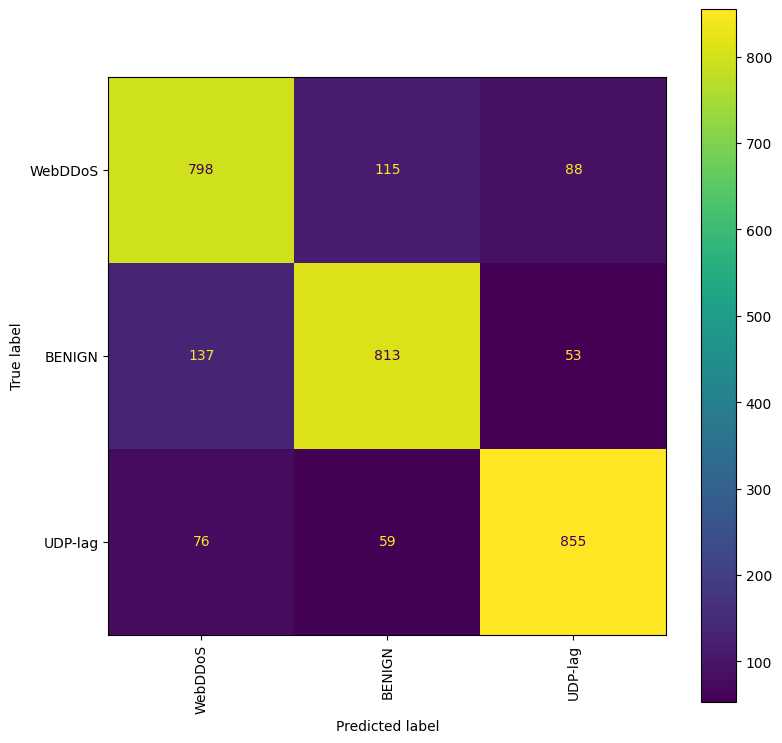

In [288]:
# -- Confusion matrix plot
# -- Confusion matrix plot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming your model predicts 3 classes based on the error message
label=np.array(["WebDDoS","BENIGN","UDP-lag"])  # Adjust if your model has different class names

cmo = ConfusionMatrixDisplay(cm,display_labels=label)
fig, ax = plt.subplots(figsize=(9,9))
cmo.plot(ax=ax, xticks_rotation=90)

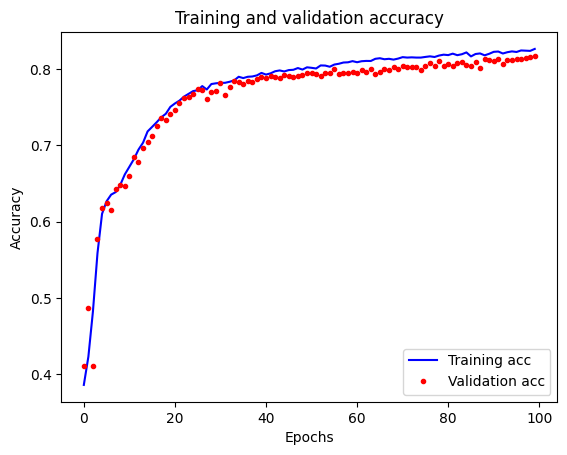

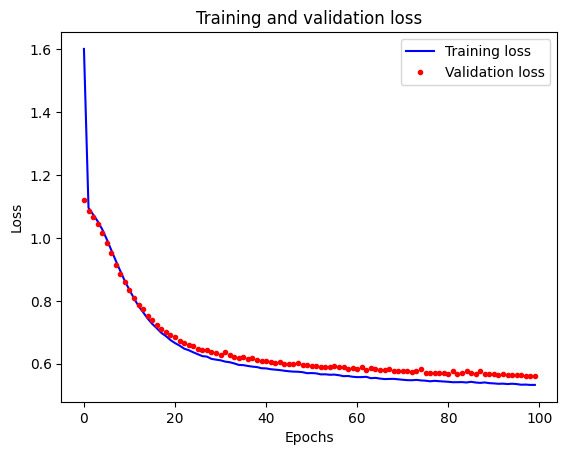

In [289]:
# Plot training and validation accurry and loss graphs
model.compile(optimizer='adam',  # Replace 'adam' with a valid optimizer like 'sgd', 'rmsprop', etc.
              loss='categorical_crossentropy',  # Replace with appropriate loss function for your task
              metrics=['accuracy'])

acc = history.history['accuracy']  # 'acc' might be 'accuracy' depending on your Keras version
val_acc = history.history['val_accuracy']  # Similarly for validation accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

np.save('historydata.npy',[acc,val_acc,loss,val_loss])
[acc, val_acc, loss, val_loss] = np.load('historydata.npy')


plt.figure()
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()